In [1]:
import pydicom as di
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
data_dir = "C:/Users/vikas/Downloads/sample/subset_0/"
patients = os.listdir(data_dir)
labels_df = pd.read_csv("C:/Users/vikas/Downloads/sample/stage1_labels.csv",index_col =0)

In [8]:
labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [7]:
patients

['0030a160d58723ff36d73f41b170ec21',
 '003f41c78e6acfa92430a057ac0b306e',
 '0092c13f9e00a3717fdc940641f00015',
 '00edff4f51a893d80dae2d42a7f45ad1',
 '0121c2845f2b7df060945b072b2515d7',
 '01de8323fa065a8963533c4a86f2f6c1',
 '01e349d34c06410e1da273add27be25c',
 '01f1140c8e951e2a921b61c9a7e782c2',
 '024efb7a1e67dc820eb61cbdaa090166',
 '0257df465d9e4150adef13303433ff1e',
 '0268f3a7a17412178cfb039e71799a80',
 '026be5d5e652b6a7488669d884ebe297',
 '031b7ec4fe96a3b035a8196264a8c8c3',
 '03bd22ed5858039af223c04993e9eb22',
 '03fb0d0fdb187ee1160f09386b28c3f2',
 '043ed6cb6054cc13804a3dca342fa4d0',
 '0482c444ac838adc5aa00d1064c976c1',
 '04a3187ec2ed4198a25033071897bffc',
 '04a52f49cdbfb8b99789b9e93f1ad319',
 '04a8c47583142181728056310759dea1',
 '04cfc5efa4c8c2a8944c8b9fa6cb04d1']

In [3]:
# Load the scans in given folder path
def load_scan(path):
    ds = []
    for s in os.listdir(path):
        ds.append(s)
    slices = [di.read_file((path + '/' + s),force = True) for s in ds]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [4]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

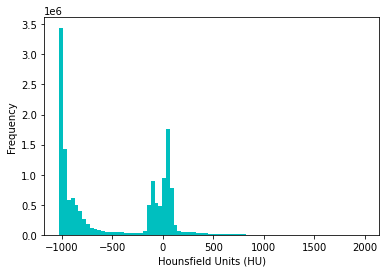

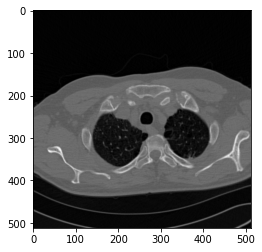

(0.0, 1.0, 0.0, 1.0)

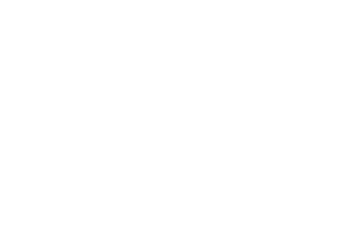

In [12]:
first_patient = load_scan(data_dir +'/'+ patients[2])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
#print(first_patient)
#print(first_patient_pixels)
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[2], cmap=plt.cm.gray)
plt.show()
plt.axis('off')

In [13]:
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage as ndimage

In [14]:
test_patient_scans = load_scan(data_dir +'/'+ patients[1])
test_patient_images = get_pixels_hu(test_patient_scans)

Original Slice


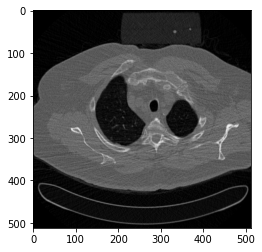

In [15]:

print ("Original Slice")
plt.imshow(test_patient_images[10], cmap='gray')
plt.show()

Internal Marker


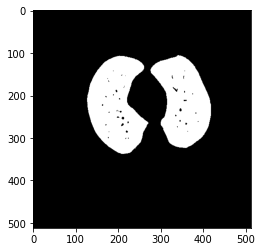

External Marker


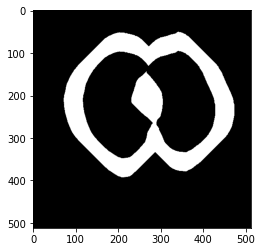

Watershed Marker


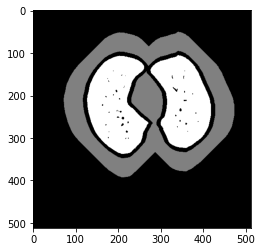

In [18]:
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

#Show some example markers from the middle        
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(test_patient_images[20])
print ("Internal Marker")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(test_patient_external, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()

(-0.5, 511.5, 511.5, -0.5)

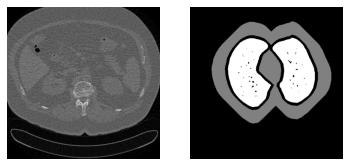

In [20]:
plt.subplot(121)
plt.imshow(test_patient_images[100],cmap = 'gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(test_patient_watershed,cmap = 'gray')
plt.axis('off')

Lung Nodule


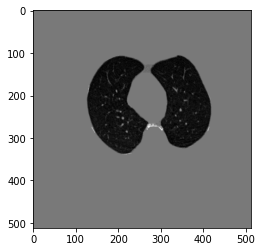

Sobel Gradient


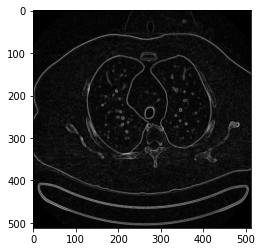

Watershed Image


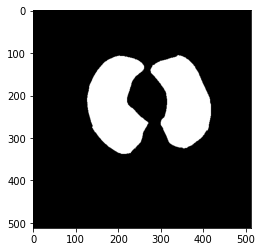

Outline after reinclusion


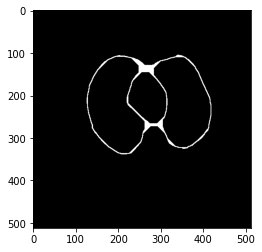

Lungfilter after closing


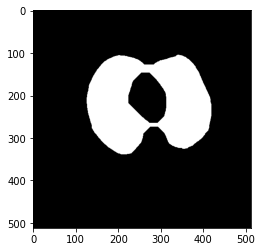

Segmented Lung


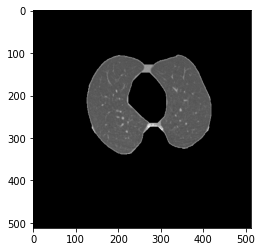

In [21]:
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = segmentation.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((7,7)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))

    #### nodule
    lung_nodule_1 = np.bitwise_or(marker_internal, image)
    lung_nodule = np.where(lungfilter == 1, lung_nodule_1, np.zeros((512, 512)))

    
    return segmented, lung_nodule, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed

#Some Testcode:
test_segmented, lung_nodule, test_lungfilter, test_outline, test_watershed, test_sobel_gradient, test_marker_internal, test_marker_external, test_marker_watershed = seperate_lungs(test_patient_images[20])

print ("Lung Nodule")
plt.imshow(lung_nodule, cmap='gray')
plt.show()
print ("Sobel Gradient")
plt.imshow(test_sobel_gradient, cmap='gray')
plt.show()
print ("Watershed Image")
plt.imshow(test_watershed, cmap='gray')
plt.show()
print ("Outline after reinclusion")
plt.imshow(test_outline, cmap='gray')
plt.show()
print ("Lungfilter after closing")
plt.imshow(test_lungfilter, cmap='gray')
plt.show()
print ("Segmented Lung")
plt.imshow(test_segmented, cmap='gray')
plt.show()

In [22]:
data = []
labels = []
print('*'*30)
print("data in converting.......")
print('*'*30)
j = 1
for patient in patients:
    test_patient_scans = load_scan(data_dir +'/'+ patients[j])
    test_patient_images = get_pixels_hu(test_patient_scans)
    path = data_dir +'/'+ patient
    ds = []
    for s in os.listdir(path):
        if( s != '.DS_Store'):
            ds.append(s)
    slices = [di.read_file((path + '/' + s),force=True) for s in ds]
    print("patient_number_{}".format(j))
    i = 0
    for s in slices:
        try:
          i += 1
          if i in range(0,50):
            continue
          #taking 100 slices from each patient
          elif i in range(50, 150):
            img = test_patient_images[i]
            seg_img = seperate_lungs(img)[0]
            new_img = np.expand_dims(seg_img,axis = -1)
            label = labels_df.at[(str(s.PatientID), 'cancer')]
            data.append(new_img)
            labels.append(label)
        
            print("converted image is : "+str(len(labels)))
          else:
            break
        except IndexError:
          continue
    j += 1
        

print("Done")

******************************
data in converting.......
******************************
patient_number_1
patient_number_2
converted image is : 1
converted image is : 2
converted image is : 3
converted image is : 4
converted image is : 5
converted image is : 6
patient_number_3
converted image is : 7
converted image is : 8
converted image is : 9
converted image is : 10
converted image is : 11
converted image is : 12
converted image is : 13
patient_number_4
converted image is : 14
converted image is : 15
converted image is : 16
converted image is : 17
converted image is : 18
converted image is : 19
converted image is : 20
converted image is : 21
converted image is : 22
converted image is : 23
converted image is : 24
converted image is : 25
converted image is : 26
converted image is : 27
patient_number_5
patient_number_6
patient_number_7
patient_number_8
converted image is : 28
converted image is : 29
converted image is : 30
converted image is : 31
converted image is : 32
converted image i

ValueError: The length of the pixel data in the dataset (115234 bytes) doesn't match the expected length (524288 bytes). The dataset may be corrupted or there may be an issue with the pixel data handler.

In [23]:

print(len(data))
#print(len(ids))# both lists, with columns specified 
print(len(labels))

57
57


In [24]:
data_new = np.array(data)
data_new.shape

(57, 512, 512, 1)

In [25]:

labels_new = np.array(labels)
labels_new.shape

(57,)

In [26]:
import os
import random
import tensorflow as tf
import time
import numpy as np
from tqdm import tqdm
from keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import decode_predictions, preprocess_input
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge,Input
from sklearn.utils import shuffle
from keras.models import Model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

In [28]:
from skimage.transform import  resize
import numpy as np
data_new = np.zeros((len(data),224,224,3))
for i in range(len(data)):
  image = data[i]
  image_resize =  resize(image, (224, 224), anti_aliasing=True)
  data_new[i] = image_resize
data_new.shape

(57, 224, 224, 3)

In [31]:
from numpy import save
print("saving data")
save("C:/Users/vikas/Downloads/sample/data_channel_3_resized.npy",data_new)

saving data


In [32]:
print("saving labels")
save("C:/Users/vikas/Downloads/sample/labels_channel_3_3.npy",labels_new)

saving labels


In [33]:
from numpy import load
print("loading data")
data = load("C:/Users/vikas/Downloads/sample/data_channel_3_resized.npy")
print("loading labels")
labels = load("C:/Users/vikas/Downloads/sample/labels_channel_3_3.npy")

loading data
loading labels


In [34]:
data.shape

(57, 224, 224, 3)

In [35]:
labels.shape

(57,)

In [36]:
j = 0
for i in labels:
  if i == 1:
    j = j+1
print(j)

14


In [37]:
print("there are {} cancer patients in this dataset".format(j))

there are 14 cancer patients in this dataset


In [128]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.1, stratify=labels, random_state=42,shuffle = True)

In [129]:
trainX.shape

(51, 224, 224, 3)

In [130]:
trainY.shape

(51,)

In [131]:
from keras.preprocessing.image import ImageDataGenerator
aug_train = ImageDataGenerator(rescale= 1.0/255.,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

aug_test  = ImageDataGenerator(rescale= 1.0/255.)

In [132]:
aug_train.fit(trainX)

In [133]:
NAME = "test_5-{}".format(int(time.time()))

In [134]:
image_input = Input(shape=(224,224,3))

model = VGG19(input_tensor=image_input, include_top = True, weights = 'imagenet')

model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [135]:
last_layer = model.get_layer('fc2').output
x = Dense(128, activation='relu', name='fc3')(last_layer)
x = Dense(128, activation='relu', name='fc4')(x)
out = Dense(1, activation = 'sigmoid', name = 'output')(x)
custom_vgg_model = Model(image_input, out)

In [136]:

for layer in custom_vgg_model.layers[:-4]:
    layer.trainable = False

custom_vgg_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

custom_vgg_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [137]:
callbacks_5 = []

In [138]:
batch_size = 32
hist_5 = custom_vgg_model.fit(aug_train.flow(trainX, trainY, batch_size=32), steps_per_epoch=len(trainX)//batch_size, epochs = 50, verbose = 1,
                        validation_data = (testX, testY), callbacks=callbacks_5)

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.7503 - accuracy: 0.0000e+00 - val_loss: 19.3733 - val_accuracy: 0.8333
Epoch 2/50
1/1 [==============================] - 8s 8s/step - loss: 3.8355 - accuracy: 0.8125 - val_loss: 164.1270 - val_accuracy: 0.1667
Epoch 3/50
1/1 [==============================] - 5s 5s/step - loss: 11.4491 - accuracy: 0.2105 - val_loss: 17.9963 - val_accuracy: 0.8333
Epoch 4/50
1/1 [==============================] - 8s 8s/step - loss: 4.4319 - accuracy: 0.7812 - val_loss: 34.8712 - val_accuracy: 0.8333
Epoch 5/50
1/1 [==============================] - 5s 5s/step - loss: 4.8010 - accuracy: 0.8421 - val_loss: 23.2032 - val_accuracy: 0.8333
Epoch 6/50
1/1 [==============================] - 5s 5s/step - loss: 9.4515 - accuracy: 0.6842 - val_loss: 8.4765e-25 - val_accuracy: 1.0000
Epoch 7/50
1/1 [==============================] - 5s 5s/step - loss: 3.9104 - accuracy: 0.7368 - val_loss: 37.7074 - val_accuracy: 0.6667
Epoch 8/50
1/1 [=========

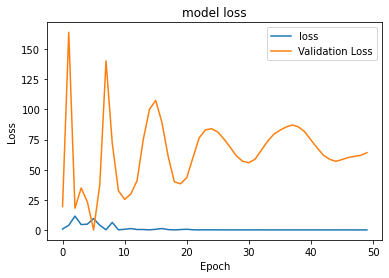

In [139]:
# print loss graph
import matplotlib.pyplot as plt
plt.plot(hist_5.history['loss'])
plt.plot(hist_5.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

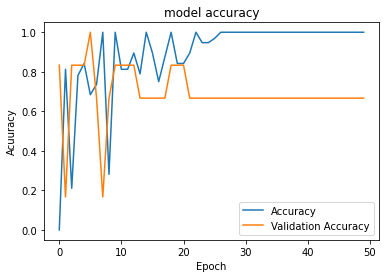

In [140]:
# print accuracy graph
plt.plot(hist_5.history["accuracy"])
plt.plot(hist_5.history['val_accuracy'])
plt.title("model accuracy")
plt.legend(["Accuracy","Validation Accuracy"])
plt.ylabel("Acuuracy")
plt.xlabel("Epoch")
plt.show()

In [141]:
predY = custom_vgg_model.predict(testX)
print(predY)

[[0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [142]:
testY

array([0, 0, 0, 1, 0, 0], dtype=int64)

In [145]:
from sklearn.metrics import accuracy_score
accuracy_score(testY, predY)

0.6666666666666666

In [146]:
from sklearn.metrics import confusion_matrix
confusion_matrix(testY, predY)

array([[3, 2],
       [0, 1]], dtype=int64)

In [149]:
from sklearn.metrics import classification_report
print(classification_report(testY, predY))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.33      1.00      0.50         1

    accuracy                           0.67         6
   macro avg       0.67      0.80      0.62         6
weighted avg       0.89      0.67      0.71         6

